In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
path = '/Users/tuethomsen28/Google Drev/SocialDataVizz/Data/'

df_befolk = pd.read_csv(os.path.join(path,"Dag_og_natbefolk.csv"),sep=";",index_col=0)

focus_municipality = ["Albertslund","Ballerup","Brøndby","Dragør","Frederiksberg","Gentofte","Gladsaxe",
                           "Glostrup","Herlev","Hvidovre","Høje-Taastrup","Ishøj","København",
                           "Rødovre","Tårnby","Vallensbæk"]

#Downloading unemployment percentage
df_unemployment = pd.read_excel(os.path.join(path,'Data_fuldtidsledige.xlsx'))
df_unemployment = df_unemployment[df_unemployment.Municipality.isin(focus_municipality)].set_index("Municipality").loc[focus_municipality]

#Downloading and calculating % highly educated
df_education = pd.read_csv(os.path.join(path,"Uddannelsesniveau.csv"),sep=";",index_col=0)
df_education = df_education.loc[focus_municipality]
df_pct_high_education = df_education.copy()
df_pct_high_education = pd.DataFrame(df_pct_high_education.iloc[:,6:].sum(1) / df_pct_high_education.sum(1),
                                     columns = ["pct_highly_educated"])

#Downloading ethnicity data and calculating percentage from non-vestern background
df_ethnicity = pd.read_csv(os.path.join(path,"ethnicity.csv"),sep=";",index_col=0)

df_pct_ethnicity = df_ethnicity[["Indvandrere fra ikke-vestlige lande","Efterkommere fra ikke-vestlige lande"]].sum(1)/df_ethnicity[
    ["Personer med dansk oprindelse","Indvandrere fra vestlige lande","Efterkommere fra vestlige lande"]].sum(1)

df_pct_ethnicity = pd.DataFrame(df_pct_ethnicity,columns=["pct_not_vestern"])

df_pct_ethnicity = df_pct_ethnicity.loc[focus_municipality]

#Downloading disposable income
df_income = pd.read_excel(os.path.join(path,'Income2.xlsx'))
df_income.columns = ["Kommune","Income"]
df_income = df_income.set_index("Kommune")
df_income = df_income.loc[focus_municipality]

#Downloading covid per data and municipality data
df_covid = pd.read_csv(os.path.join(path,"Corona_hosp_1603_2204.csv"),index_col=0)
df_covid["Total"] = df_covid.sum(1)
df_covid = df_covid.rename(columns={"Taarnby":"Tårnby"})

## and calculating average percentage fall after maximum hospitalisations
df_covid_max = df_covid[df_covid.index < "2020-04-01"].max()
df_covid_avg_after = df_covid[df_covid.index > "2020-04-01"].mean(0)
df_covid_decrease = pd.DataFrame((df_covid_max - df_covid_avg_after) / df_covid_max,columns=["covid_decrease"])
df_covid_decrease = df_covid_decrease.iloc[:-1]

#Downloading mean covid hosps per mun
df_mean_hosp = pd.read_csv(os.path.join(path,"mean_hosp_per_mun.csv"),index_col=0)
df_mean_hosp = df_mean_hosp.rename(index={"Taarnby":"Tårnby"})

#Download mean passenger decrease per municipality
df_passenger = pd.read_csv(os.path.join(path,"passenger_decrease.csv"),index_col=0)

#Downloading and calculating change in speed per municipality
df_hast_daily = pd.read_csv(os.path.join(path,"speedPerMun.csv"),sep=";")
df_hast_daily = df_hast_daily.set_index("Date")

df_avg_hast_pre_lockdown = df_hast_daily[df_hast_daily.index < "2020-03-11"].mean(0)

df_avg_hast_post_lockdown = df_hast_daily[df_hast_daily.index >= "2020-03-11"].mean(0)

df_hast_change = pd.DataFrame((df_avg_hast_post_lockdown - df_avg_hast_pre_lockdown)/df_avg_hast_pre_lockdown,
                             columns=["pct_increase"])

# Downloading ratio between day and night population

df_day_night = pd.read_csv(os.path.join(path,'Dag_og_natbefolk.csv'),sep=";",index_col=0)

#Calculating population density (people per km^2)
df_age_distribution = pd.read_excel(os.path.join(path,'Data_aldersfordeling.xlsx'))

def ageInt(x):
    return (int(x.split()[0]))

df_age_distribution['Age'] = df_age_distribution['Age'].apply(ageInt)

df_popu = df_age_distribution.groupby("Municipality").sum()[["Number"]].rename(columns={"Number":"Population"})

df_popu = df_popu.loc[focus_municipality]

#Data from wikipedia
df_popu["km^2"] = [23.04,34.09,20.85,18.41,8.7,25.54,25,13.31,12.04,22.90,78.41,25.94,86.4,12.12,64.95,9.23]

df_popu["Density"] = df_popu["Population"]/df_popu["km^2"]

df_age_distribution = df_age_distribution[df_age_distribution['Municipality'].isin(focus_municipality)]
df_age_distribution = df_age_distribution.sort_values(['Municipality','Age'])
focus_municipality.sort()

median_ages = []
for m in focus_municipality:
    df_tmp = df_age_distribution[df_age_distribution['Municipality']== m]
    median_num = np.round(sum(df_tmp['Number'].values)/2)
    count = 0
    for a in np.unique(df_tmp['Age']):
        count += df_tmp.iloc[a]['Number']
        if count >= median_num:
            median_ages.append(a)
            break

data = {'Municipality': focus_municipality,
        'Median age': median_ages
        }

df_median_age = pd.DataFrame(data, columns = ['Municipality', 'Median age'])
df_median_age = df_median_age.set_index("Municipality")




In [3]:
# Creating df containing all info

df = df_popu[["Density"]].copy()
df["DagNatRatio"] = df_day_night["NatDagRatio"]
df["pct_unemployed"] = df_unemployment["2020M02"]
df["pct_highly_educated"] = df_pct_high_education["pct_highly_educated"]
df["pct_not_vestern"] = df_pct_ethnicity["pct_not_vestern"]
df["income"] = df_income["Income"]
df["median_age"] = df_median_age["Median age"]

df["speed_change"] = df_hast_change["pct_increase"]
df["passenger_change"] = df_passenger["pct_drop_2020"]
df["covid_mean_per_100000"] = df_mean_hosp.mean_hosp
df["covid_decrease"] = df_covid_decrease["covid_decrease"]

df.to_csv(os.path.join(path,"allVariables.csv"))

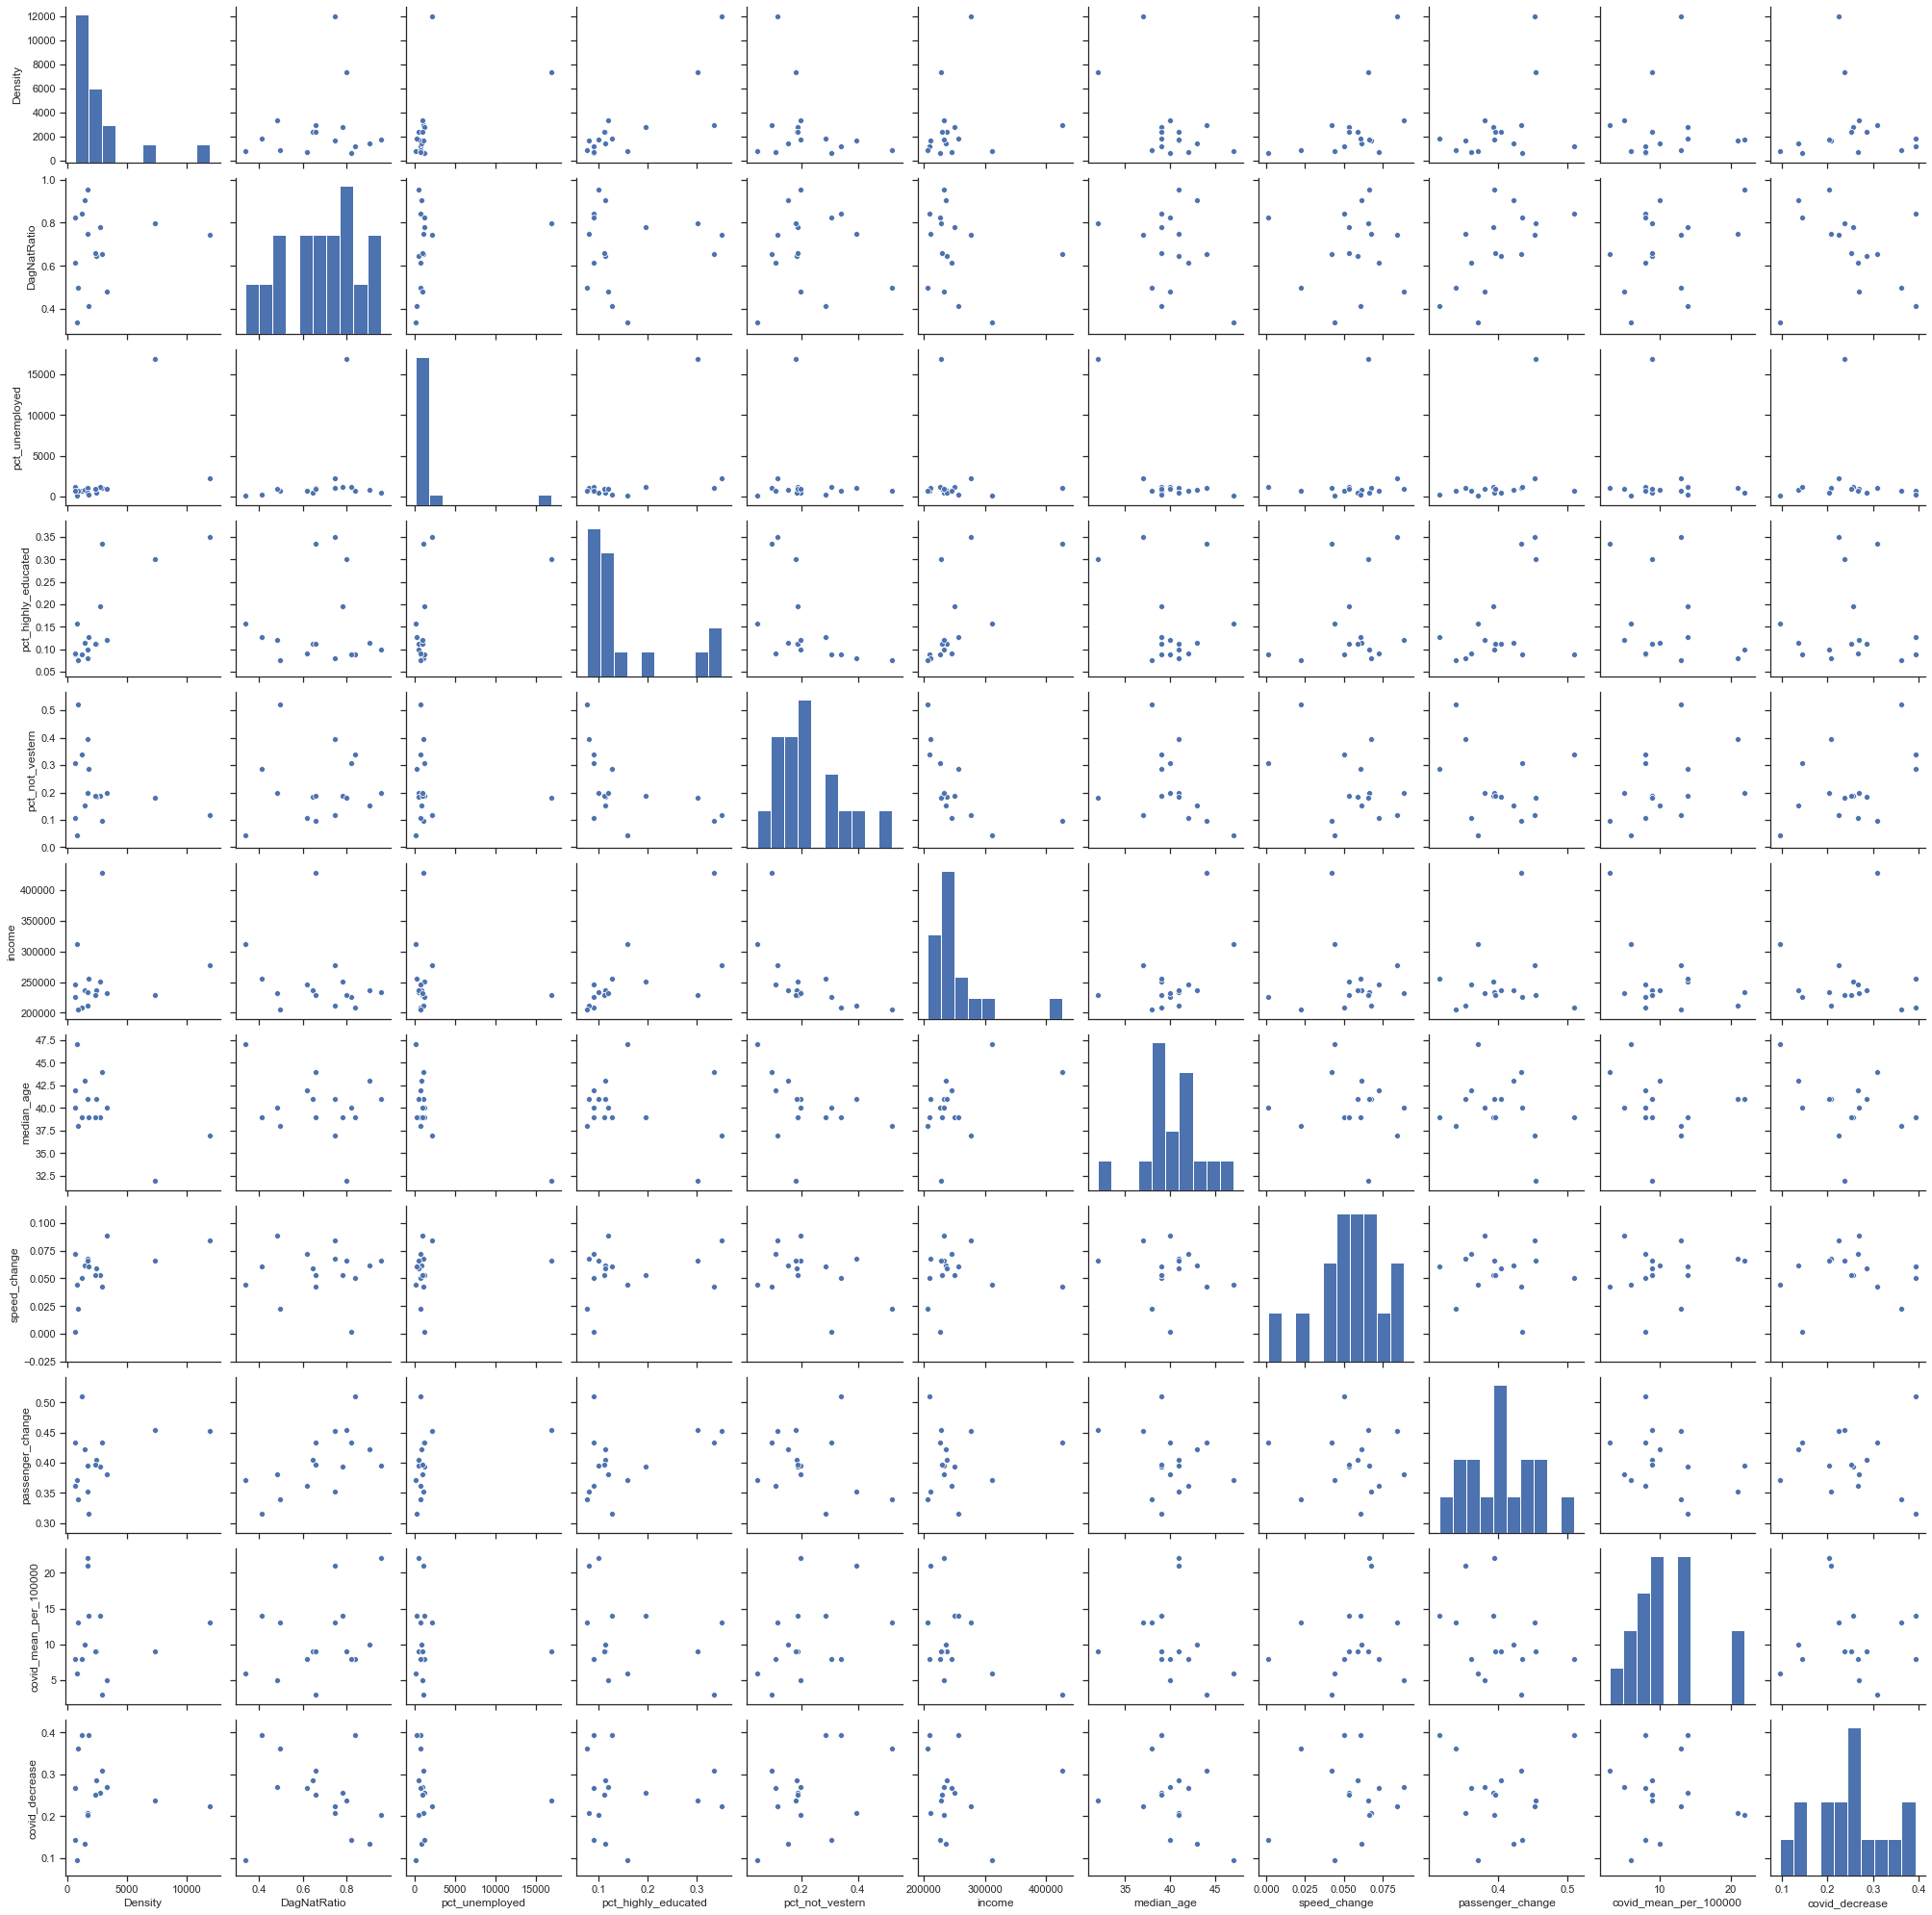

In [4]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df)

In [5]:
correlations = (df.corr()**2).round(3)
correlations

,Density,DagNatRatio,pct_unemployed,pct_highly_educated,pct_not_vestern,income,median_age,speed_change,passenger_change,covid_mean_per_100000,covid_decrease
Density,1.000,0.025,0.244,0.631,0.090,0.020,0.313,0.237,0.152,0.001,0.001
DagNatRatio,0.025,1.000,0.047,0.004,0.001,0.061,0.074,0.000,0.378,0.128,0.047
pct_unemployed,0.244,0.047,1.000,0.238,0.008,0.010,0.486,0.020,0.112,0.007,0.004
pct_highly_educated,0.631,0.004,0.238,1.000,0.261,0.420,0.067,0.054,0.166,0.063,0.001
pct_not_vestern,0.090,0.001,0.008,0.261,1.000,0.342,0.124,0.156,0.045,0.172,0.200
income,0.020,0.061,0.010,0.420,0.342,1.000,0.224,0.002,0.007,0.196,0.003
median_age,0.313,0.074,0.486,0.067,0.124,0.224,1.000,0.021,0.064,0.040,0.132
speed_change,0.237,0.000,0.020,0.054,0.156,0.002,0.021,1.000,0.002,0.032,0.003
passenger_change,0.152,0.378,0.112,0.166,0.045,0.007,0.064,0.002,1.000,0.109,0.004
covid_mean_per_100000,0.001,0.128,0.007,0.063,0.172,0.196,0.040,0.032,0.109,1.000,0.001


In [6]:
#correlations = correlations[correlations > 0.15]

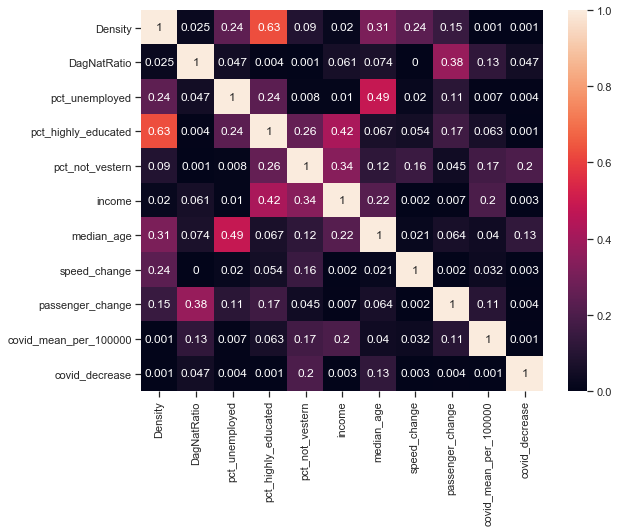

In [7]:
plt.figure(figsize=(9,7))
sns.heatmap(correlations,annot=True)

In [8]:
correlations2 = correlations[["speed_change","passenger_change","covid_mean_per_100000","covid_decrease"]]

correlations2 = correlations2.loc[["Density","DagNatRatio","pct_unemployed","pct_highly_educated","pct_not_vestern",
                                   "income","median_age"]]

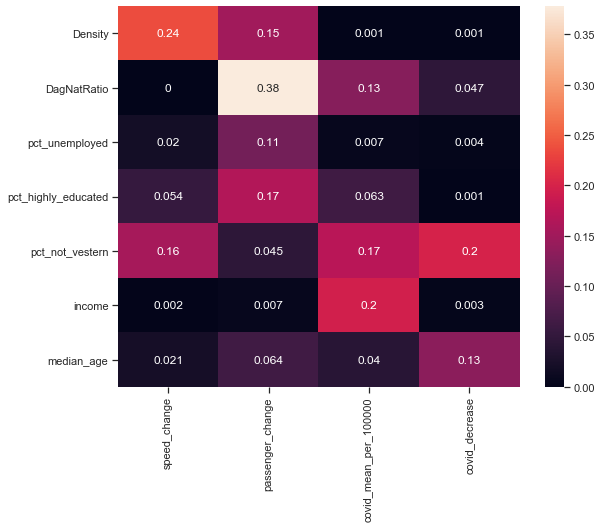

In [9]:
plt.figure(figsize=(9,7))
sns.heatmap(correlations2,annot=True)

# Performing PCA on variables

In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

variables = ["Density","DagNatRatio","pct_unemployed","pct_highly_educated","pct_not_vestern","income","median_age"]

# PCA on all

# Explore need of how many PCA's for all variables

In [11]:
pca = PCA(n_components=10)

PC = pca.fit_transform(x)

variance_per_PCA = pca.explained_variance_ratio_

accumulated_variance = []

for i in range(1,11):
    accumulated_variance += [variance_per_PCA[:i].sum()]

plt.plot(list(range(1,11)),variance_per_PCA,label="Explained variance per PC")
plt.plot(list(range(1,11)),accumulated_variance,"r-",label="Accumulated explained variance")

threshold = 0.80

plt.hlines(threshold,xmin=0,xmax=11,linestyles="dashed",label="Threshold")
plt.xticks(ticks=list(range(1,11)))
plt.xlim(0,11)
plt.legend()

print(variance_per_PCA)

NameError: name 'x' is not defined

# Excluding corona numbers

In [ ]:
#Standardise values before applying PCA
features_excluding_covid = variables +["speed_change","passenger_change"]
x = df[features_excluding_covid].values

x = StandardScaler().fit_transform(x)

df_std = pd.DataFrame(data = x, columns = features_excluding_covid)
df_std

In [ ]:
components

In [ ]:
pca = PCA(n_components=9)

PC = pca.fit_transform(x)

components = pca.components_

variance_per_PCA = pca.explained_variance_ratio_

accumulated_variance = []

for i in range(1,10):
    
    accumulated_variance += [variance_per_PCA[0:i].sum()]

plt.plot(list(range(1,10)),variance_per_PCA,label="Explained variance per PC")
plt.plot(list(range(1,10)),accumulated_variance,"r-",label="Accumulated explained variance")

threshold = 0.80

plt.hlines(threshold,xmin=0,xmax=11,linestyles="dashed",label="Threshold")
plt.xticks(ticks=list(range(1,10)))
plt.xlim(0,11)
plt.legend()

In [ ]:
PC_list = ["PC"+str(i) for i in range(1,5)]

pca = PCA(n_components=4)

PC = pca.fit_transform(x)

components = pca.components_

PC_4D = pd.DataFrame(components,columns=features_excluding_covid,index=PC_list).T

plt.figure(figsize=(9,7))
sns.heatmap(PC_4D,annot=True)

In [ ]:
PC_4D["variable"] = PC_4D.index
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
PC_4D.plot(x = "variable",y=PC_list,kind="bar",grid=True)

In [ ]:
colors = plt.cm.autumn(np.linspace(1,0,16))

df_std.index = df.index

df_std_sorted = df_std.sort_values("speed_change")

PC_color = pca.fit_transform(df_std_sorted)

for i in range(16):
    pc1 = 3
    pc2 = 0
    
    plt.plot(PC_color[i,pc1],PC_color[i,pc2],"o",color=colors[i])
    plt.xlabel(f"PC{pc1+1}")
    plt.ylabel(f"PC{pc2+1}")

In [ ]:
colors = plt.cm.autumn(np.linspace(1,0,16))

df_std.index = df.index

c = df_std.sort_values("passenger_change")

PC_color = pca.fit_transform(df_std_sorted)


for i in range(16):
    pc1 = 2
    pc2 = 3
    
    plt.plot(PC_color[i,pc1],PC_color[i,pc2],"o",color=colors[i])
    plt.xlabel(f"PC{pc1+1}")
    plt.ylabel(f"PC{pc2+1}")

In [ ]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, FactorRange, Legend, HoverTool
from bokeh.transform import dodge
import bokeh.palettes
import math
output_notebook()
%matplotlib inline

## Prepare data ##################################################################################

variables = ["Density","DagNatRatio","pct_unemployed","pct_highly_educated",
             "pct_not_vestern","income","median_age","speed_change","passenger_change"]

sel_mun = [
           "Albertslund",
           "Ballerup","Brøndby","Dragør","Frederiksberg","Gentofte","Gladsaxe",
                           "Glostrup","Herlev","Hvidovre","Høje-Taastrup","Ishøj","København",
                           "Rødovre","Tårnby","Vallensbæk"]

path = '/Users/tuethomsen28/Google Drev/SocialDataVizz/Data/'

df = pd.read_csv(os.path.join(path,"allVariables.csv"),sep=",",index_col=0)

#df = df[df.index != "Albertslund"]

x = df[variables].values

x = StandardScaler().fit_transform(x)

df_std = pd.DataFrame(data = x, columns = variables)

pca = PCA(n_components=4)

PC = pca.fit_transform(df_std)

components = pca.components_

PC_list = ["PC"+str(i) for i in range(1,5)]

PC_4D = pd.DataFrame(components,columns=variables,index=PC_list).T

## Create plot ###################################################################################

#Creating format fitting for bokeh
source = ColumnDataSource(PC_4D)

#Creating a list for the x-axis on the bar-chart. 
x_range = [str(h) for h in source.data['index']]

#Generating 14 colors for the different focus crimes  
colors = bokeh.palettes.Category20[18][0::2]

bar ={} # to store vbars

#Creating figure frame with title, x -and y labels and disabling toolbar. 
p = figure(x_range=FactorRange(factors=x_range),
           title='Principal Component Coefficients',
           x_axis_label='Variables',
           y_axis_label='Coefficients',
           plot_width=950,plot_height=500,
           toolbar_location = None)


PCs = ["PC1","PC2","PC3","PC4"]

#Generating barcharts to p 
for indx,i in enumerate(PCs):
    bar[i] = p.vbar("index",  top=i, source= source, width=0.5, 
                 fill_alpha=0.5,line_color=None,
                 color=colors[indx],visible=False)
    
p.xaxis.major_label_orientation = math.pi/4

items = [(i,[bar[i]]) for i in PCs] #Creating list of tuples with focus crime name and belonging bar chart.
legend = Legend(items=items,location=(0,225),) # Creating legends with 'items'
p.add_layout(legend,"right") # Adding legends to ´p´ and setting location. 

p.legend.click_policy="hide"
p.legend.title = 'Click on names below to see barcharts'
    
    
show(p)

In [ ]:
df_color["speed_color"] = [colormap_speed(df.loc[m,"speed_change"]) for m in sel_mun]

df_color

In [ ]:
df

In [ ]:
############ prepare data ##############################################################################################
from branca.colormap import linear
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from bokeh.layouts import layout, gridplot, row, column, widgetbox
%matplotlib inline

variables = ["Density","DagNatRatio","pct_unemployed","pct_highly_educated",
             "pct_not_vestern","income","median_age","speed_change","passenger_change"]

sel_mun = [
           "Albertslund",
           "Ballerup","Brøndby","Dragør","Frederiksberg","Gentofte","Gladsaxe",
                           "Glostrup","Herlev","Hvidovre","Høje-Taastrup","Ishøj","København",
                           "Rødovre","Tårnby","Vallensbæk"]

path = '/Users/tuethomsen28/Google Drev/SocialDataVizz/Data/'

df = pd.read_csv(os.path.join(path,"allVariables.csv"),sep=",",index_col=0)

#df = df[df.index != "Albertslund"]

x = df[variables].values

x = StandardScaler().fit_transform(x)

df_std = pd.DataFrame(data = x, columns = variables)

pca = PCA(n_components=4)

PC_color = pca.fit_transform(df_std)

df_color = pd.DataFrame(PC_color,index=sel_mun,columns=["PC1","PC2","PC3","PC4"])


colormap_speed = linear.YlGn_09.scale(df.speed_change.min(),df.speed_change.max())
colormap_passenger = linear.YlGn_07.scale(df.passenger_change.min(),df.passenger_change.max())


df_color["speed_change"] = df["speed_change"]*100
df_color["passenger_change"] = df["passenger_change"]*100

df_color["speed_color"] = [colormap_speed(df.loc[m,"speed_change"]) for m in sel_mun]
df_color["passenger_color"] = [colormap_passenger(df.loc[m,"passenger_change"]) for m in sel_mun]


########### Create figure #########################################################################################################
source = ColumnDataSource(data = df_color)


TOOLTIPS_speed = [("Municipality: ", "@index"),
            ("% increase in speed", "@speed_change{0.2f}%")]

TOOLTIPS_passenger = [("Municipality: ", "@index"),
            ("% decrease in passengers", "@passenger_change{0.2f}%")]


# create figure
s = figure(plot_height = 400, plot_width = 400,
    title = 'PC1 and PC3',
           x_axis_label='Principal Component 1',
           y_axis_label='Principal Component 3',
           background_fill_color = "white",background_fill_alpha = 0.8, 
           border_fill_color = "white", border_fill_alpha = 0.8, tooltips=TOOLTIPS_speed,
           #y_axis_type="log"
           toolbar_location = None,
          )

# create figure
p = figure(plot_height = 400, plot_width = 400,
    title = 'PC1 and PC4',
           x_axis_label='Principal Component 1',
           y_axis_label='Principal Component 4',
           background_fill_color = "white",background_fill_alpha = 0.8, 
           border_fill_color = "white", border_fill_alpha = 0.8, tooltips=TOOLTIPS_passenger,
           #y_axis_type="log"
           toolbar_location = None
     
          )

speed_colors = []
    
# Create plot
s.circle(x = "PC1", y = 'PC3', size=15,source=source,color="speed_color",line_alpha=1,line_color="black")
p.circle(x = "PC1", y = 'PC4', size=15,source=source,color="passenger_color",line_alpha=1,line_color="black")

#p.line([-2.5, 4.5], [2.2, -1.5], line_color="black")


show(row(s,p))

    